## Run enface for all in predictions folder

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from torchvision import models
from PIL import Image
import os
import math
from tqdm import tqdm
import cv2
import json
import re

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [3]:
# Load the trained model from .pth file
class VGG16BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16BinaryClassifier, self).__init__()

        # Load VGG-16 model
        self.vgg16 = models.vgg16(pretrained=pretrained)

        # Freeze convolutional layers (optional)
        for param in self.vgg16.features.parameters():
            param.requires_grad = True  # Set to True if you want to fine-tune

        # Modify the classifier head for binary classification
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # VGG-16's default input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),  # Custom hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)  # Output 1 logit (for binary classification)
        )

    def forward(self, x):
        return self.vgg16(x)  # No sigmoid, return raw logits

# Function to load the trained model
def load_model(model_path, device):
    # Instantiate the model
    model = VGG16BinaryClassifier(pretrained=True)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    # print(model)
    return model

# Load model
model_path = "best_VGG_model_1.pth"  
model = load_model(model_path,device)

# Select the target convolutional layer (last conv layer in VGG16 features block)
target_layer = model.vgg16.features[28]  # Last conv layer before FC layers

/opt/anaconda3/envs/clinical_ai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/clinical_ai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_2507/1385931762.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https:

In [4]:
class SaveValues():
    def __init__(self, m):
        # register a hook to save values of activations and gradients
        self.activations = None
        self.gradients = None
        self.forward_hook = m.register_forward_hook(self.hook_fn_act)
        self.backward_hook = m.register_backward_hook(self.hook_fn_grad)

    def hook_fn_act(self, module, input, output):
        self.activations = output

    def hook_fn_grad(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove(self):
        self.forward_hook.remove()
        self.backward_hook.remove()
        
class CAM(object):
    """ Class Activation Mapping """

    def __init__(self, model, target_layer):
        """
        Args:
            model: a base model to get CAM which have global pooling and fully connected layer.
            target_layer: conv_layer before Global Average Pooling
        """

        self.model = model
        self.target_layer = target_layer

        # save values of activations and gradients in target_layer
        self.values = SaveValues(self.target_layer)

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
        Return:
            heatmap: class activation mappings of the predicted class
        """

        # object classification
        score = self.model(x)

        prob = F.softmax(score, dim=1)

        if idx is None:
            prob, idx = torch.max(prob, dim=1)
            idx = idx.item()
            prob = prob.item()
            print("predicted class ids {}\t probability {}".format(idx, prob))

        # cam can be calculated from the weights of linear layer and activations
        weight_fc = list(
            self.model._modules.get('fc').parameters())[0].to('cpu').data

        cam = self.getCAM(self.values, weight_fc, idx)

        return cam, idx

    def __call__(self, x):
        return self.forward(x)

    def getCAM(self, values, weight_fc, idx):
        '''
        values: the activations and gradients of target_layer
            activations: feature map before GAP.  shape => (1, C, H, W)
        weight_fc: the weight of fully connected layer.  shape => (num_classes, C)
        idx: predicted class id
        cam: class activation map.  shape => (1, num_classes, H, W)
        '''

        cam = F.conv2d(values.activations, weight=weight_fc[:, :, None, None])
        _, _, h, w = cam.shape

        # class activation mapping only for the predicted class
        # cam is normalized with min-max.
        cam = cam[:, idx, :, :]
        cam -= torch.min(cam)
        cam /= torch.max(cam)
        cam = cam.view(1, 1, h, w)

        return cam.data
    
class ScoreCAM(CAM):
    """ Score CAM """

    def __init__(self, model, target_layer, n_batch=32):
        super().__init__(model, target_layer)
        """
        Args:
            model: a base model
            target_layer: conv_layer you want to visualize
        """
        self.n_batch = n_batch

    def forward(self, x, idx=None):
        """
        Args:
            x: input image. shape =>(1, 3, H, W)
            idx: the index of the target class
        Return:
            heatmap: class activation mappings of predicted classes
        """

        with torch.no_grad():
            orig_H, orig_W = x.shape[2], x.shape[3]  # Save original size (512x1024)
            x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

            device = x.device

            self.model.zero_grad()
            score = self.model(x_resized)
            prob = F.softmax(score, dim=1)

            if idx is None:
                p, idx = torch.max(prob, dim=1)
                idx = idx.item()
                # print("predicted class ids {}\t probability {}".format(idx, p))

            # # calculate the derivate of probabilities, not that of scores
            # prob[0, idx].backward(retain_graph=True)

            self.activations = self.values.activations.to('cpu').clone()
            # put activation maps through relu activation
            # because the values are not normalized with eq.(1) without relu.
            self.activations = F.relu(self.activations)
            self.activations = F.interpolate(self.activations, size=(224, 224), mode='bilinear')
            _, C, _, _ = self.activations.shape

            # normalization
            act_min, _ = self.activations.view(1, C, -1).min(dim=2)
            act_min = act_min.view(1, C, 1, 1)
            act_max, _ = self.activations.view(1, C, -1).max(dim=2)
            act_max = act_max.view(1, C, 1, 1)
            denominator = torch.where(
                (act_max - act_min) != 0., act_max - act_min, torch.tensor(1.)
            )

            self.activations = self.activations / denominator

            # generate masked images and calculate class probabilities
            probs = []
            for i in range(0, C, self.n_batch):
                mask = self.activations[:, i:i+self.n_batch].transpose(0, 1)
                mask = mask.to(device)
                
                # 🔹 Fix: Resize mask to match original image dimensions (512x1024)
                # mask = F.interpolate(mask, size=(orig_H, orig_W), mode='bilinear', align_corners=False)
                masked_x = x_resized * mask
                score = self.model(masked_x)
                probs.append(F.softmax(score, dim=1)[:, idx].to('cpu').data)

            probs = torch.stack(probs)
            weights = probs.view(1, C, 1, 1)

            # shape = > (1, 1, H, W)
            cam = (weights * self.activations).sum(1, keepdim=True)
            cam = F.relu(cam)
            cam -= torch.min(cam)
            cam /= torch.max(cam)

            # Resize heatmap to original image size (512x1024)
            cam = F.interpolate(cam, size=(orig_H, orig_W), mode='bilinear', align_corners=False)


        return cam.data, idx

In [7]:
# Setup
base_dir = "predictions 2"
scorecam_base = "ScoreCam"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device and eval mode
model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

scorecam = ScoreCAM(model, target_layer=target_layer)

# sample_names = sorted(os.listdir(base_dir))
sample_names = ["1019_left"]
for sample_name in sample_names:
    pred_fovea_dir = os.path.join(base_dir, sample_name, "predictions/fovea")
    if not os.path.isdir(pred_fovea_dir):
        print(f"❌ Directory not found: {pred_fovea_dir}")
        continue  # Skip if not a directory

    scorecam_mask_dir = os.path.join(scorecam_base, sample_name, "masked_images")
    scorecam_centroid_dir = os.path.join(scorecam_base, sample_name, "centroid")
    os.makedirs(scorecam_mask_dir, exist_ok=True)
    os.makedirs(scorecam_centroid_dir, exist_ok=True)

    img_filenames = sorted([
        f for f in os.listdir(pred_fovea_dir)
        if f.endswith((".png", ".jpg", ".jpeg"))
    ])

    masked_stack = []

    for img_name in tqdm(img_filenames, desc=f"Processing {sample_name}"):
        img_path = os.path.join(pred_fovea_dir, img_name)
        original_img = Image.open(img_path).convert("RGB")
        input_tensor = preprocess(original_img).unsqueeze(0).to(device)

        with torch.no_grad():
            cam = scorecam(input_tensor)[0]
            cam_np = cam.squeeze().cpu().numpy()
            cam = cv2.resize(cam_np, original_img.size)

        mask = (cam > 0.5).astype(np.uint8)
        masked_stack.append(mask)

        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        original_np = np.array(original_img)
        blended = cv2.addWeighted(original_np, 0.5, heatmap, 0.5, 0)
        cv2.imwrite(os.path.join(scorecam_mask_dir, img_name), blended)

    # Calculate centroid
    stack_array = np.stack(masked_stack, axis=0)
    overlap_mask = (np.sum(stack_array, axis=0) > (len(masked_stack) // 2)).astype(np.uint8)
    moments = cv2.moments(overlap_mask)
    cx = int(moments["m10"] / moments["m00"]) if moments["m00"] != 0 else 0
    cy = int(moments["m01"] / moments["m00"]) if moments["m00"] != 0 else 0
    print(f"📌 centroid on Bscan of {sample_name}: ({cx},{cy})")

    # Draw centroid
    mid_idx = len(img_filenames) // 2
    mid_img_path = os.path.join(pred_fovea_dir, img_filenames[mid_idx])
    mid_img = cv2.imread(mid_img_path)
    centroid_img = mid_img.copy()
    cv2.circle(centroid_img, (cx, cy), radius=5, color=(0, 0, 255), thickness=-1)

    centroid_img_path = os.path.join(scorecam_centroid_dir, f"{img_filenames[mid_idx].split('.')[0]}_centroid_{cx}x{cy}.png")
    cv2.imwrite(centroid_img_path, centroid_img)

    # Save visualization
    def show_masked_images(volume_path):
        img_filenames = sorted([
            f for f in os.listdir(volume_path)
            if f.endswith((".png", ".jpg", ".jpeg"))
        ])
        num_images_to_show = len(img_filenames)
        images_per_row = 5
        num_rows = math.ceil(num_images_to_show / images_per_row)

        fig, axes = plt.subplots(num_rows, images_per_row, figsize=(10, 3 * num_rows))
        axes = axes.flatten()
        for idx, img_name in enumerate(img_filenames):
            img = Image.open(os.path.join(volume_path, img_name))
            serial_number = img_name.split("_")[-1].split(".")[0]
            axes[idx].imshow(img)
            axes[idx].axis("off")
            axes[idx].set_title(f"SN: {serial_number}")

        for idx in range(num_images_to_show, len(axes)):
            axes[idx].axis("off")

        plt.suptitle(f"Masked images of {sample_name}", fontsize=16)
        plt.tight_layout()
        plt.savefig(os.path.join(scorecam_base, sample_name, f"masked_{sample_name}.png"))
        plt.close()

    show_masked_images(scorecam_mask_dir)

    def draw_fovea_enface(sample_name, cx, bscan_idx, enface_path, radius=10):
        def map_centroid_to_enface(cx, bscan_idx, bscan_width=1024, num_slices=128, enface_size=512):
            x_enface = cx
            y_enface = int((bscan_idx / num_slices) * enface_size)
            return x_enface, y_enface

        if not os.path.exists(enface_path):
            print(f"❌ Enface image not found at: {enface_path}")
            return

        enface_img = cv2.imread(enface_path)
        h, w = enface_img.shape[:2]
        x_enface, y_enface = map_centroid_to_enface(cx, bscan_idx)

        # --- MPS-accelerated circle mask ---
        y_grid, x_grid = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij')
        dist_sq = (x_grid - x_enface) ** 2 + (y_grid - y_enface) ** 2
        circle_mask = (dist_sq <= radius**2).to(torch.uint8) * 255  # Values: 0 or 255

        # Save mask only
        save_dir = os.path.join(scorecam_base, sample_name)
        os.makedirs(save_dir, exist_ok=True)
        mask_path = os.path.join(save_dir, "fovea_mask.png")
        cv2.imwrite(mask_path, circle_mask.cpu().numpy())

        # Draw circle on image for visualization
        annotated_img = enface_img.copy()
        cv2.circle(annotated_img, (x_enface, y_enface), radius, (0, 255, 0), thickness=1)
        save_img_path = os.path.join(save_dir, "fovea_enface.png")
        cv2.imwrite(save_img_path, annotated_img)

        print(f"✅ Saved binary mask to {mask_path}")
        print(f"✅ Saved annotated image to {save_img_path}")

    match = re.search(r"bscan_(\d+)_centroid_(\d+)x\d+", centroid_img_path)
    img_at_mid = int(match.group(1)) 
    cx = int(match.group(2)) 
    enface_path = input("Enter the path to the enface image: ")
    draw_fovea_enface(sample_name, cx, img_at_mid, enface_path)

Processing 1019_left: 100%|██████████| 31/31 [28:43<00:00, 55.59s/it]


📌 centroid on Bscan of 1019_left: (288,319)
✅ Saved binary mask to ScoreCam/1019_left/fovea_mask.png
✅ Saved annotated image to ScoreCam/1019_left/fovea_enface.png


## Mapping gradient heatmap on Enface image

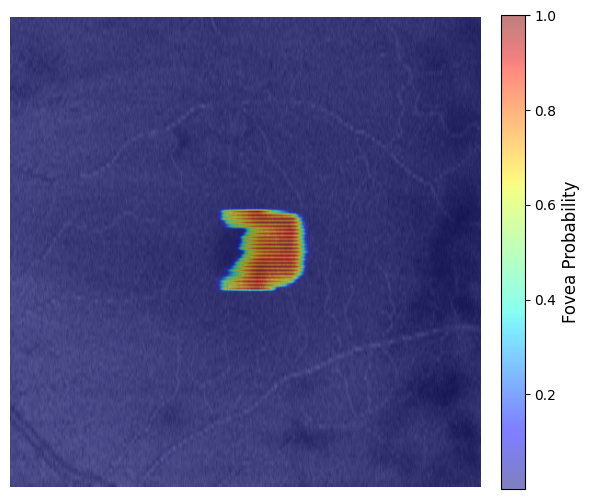

In [25]:
import cv2
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, gaussian_filter

def generate_fovea_probability_map(enface_path, scorecam_mask_dir, num_slices=128):
    # === Load enface image ===
    enface_img = cv2.imread(enface_path)
    enface_img = cv2.resize(enface_img, (512, 512))

    # === Init heatmap canvas ===
    prob_map = np.zeros((512, 512), dtype=np.float32)
    y_positions = []

    # === Read ScoreCAM files ===
    img_filenames = sorted([
        f for f in os.listdir(scorecam_mask_dir)
        if f.endswith((".png", ".jpg", ".jpeg"))
    ])

    for img_name in img_filenames:
        img_path = os.path.join(scorecam_mask_dir, img_name)
        cam = cv2.imread(img_path)
        if cam is None:
            continue

        # === Extract index from filename ===
        match = re.search(r'bscan_(\d+)', img_name)
        if not match:
            continue
        idx = int(match.group(1))
        y_pos = int((idx / num_slices) * 512)
        y_positions.append(y_pos)

        # Resize and roll
        cam = cv2.resize(cam, (512, 512))
        cam = np.roll(cam, shift=-4, axis=1)

        # Extract ScoreCAM red/yellow (active) parts
        hsv = cv2.cvtColor(cam, cv2.COLOR_BGR2HSV)
        mask1 = cv2.inRange(hsv, (0, 50, 50), (10, 255, 255))
        mask2 = cv2.inRange(hsv, (160, 50, 50), (180, 255, 255))
        mask = cv2.bitwise_or(mask1, mask2)

        # Collapse vertically to horizontal profile
        profile = np.sum(mask, axis=0).astype(np.float32)
        profile = gaussian_filter1d(profile, sigma=2)

        if profile.max() > 0:
            profile /= profile.max()

        # Add profile to map at y_pos
        prob_map[y_pos, :] = profile

    # === Fill above & below missing lines with 0 ===
    if y_positions:
        y_min, y_max = min(y_positions), max(y_positions)
        for y in range(0, y_min):
            prob_map[y, :] = 0.0
        for y in range(y_max + 1, 512):
            prob_map[y, :] = 0.0

    # === Smooth vertically ===
    prob_map = gaussian_filter(prob_map, sigma=(1.5, 1.5))
    prob_map /= prob_map.max() + 1e-6  # normalize

    return enface_img, prob_map

# === Run it ===
enface_path = "imgs/1002/20230801/153134/L/OCT/Carl_Zeiss_Meditec_CIRRUS_5000(512x1024x128)/ImageAnalysis/ILM_RPE_Enface/1002_20230801_153134_L_OCT_512x1024x128_ILM_RPE_Enface.jpg"
scorecam_mask_dir = "ScoreCam/1002_left/masked_images"

enface_img, probability_map = generate_fovea_probability_map(enface_path, scorecam_mask_dir)

# === Show with colorbar ===
plt.figure(figsize=(6, 6))
plt.imshow(enface_img, cmap='gray')
heat = plt.imshow(probability_map, cmap='jet', alpha=0.5)
cbar = plt.colorbar(heat, fraction=0.046, pad=0.04)
cbar.set_label("Fovea Probability", fontsize=12)
cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])
plt.axis("off")
plt.tight_layout()
plt.show()
